### 📦 Import Libraries

Pada cell ini, kita mengimpor semua library dan modul yang dibutuhkan untuk proyek klasifikasi citra, yang meliputi:

- **Library standar**: `os`, `numpy`, `pandas` untuk manipulasi file dan data.
- **Visualisasi**: `matplotlib.pyplot`, `seaborn` untuk visualisasi data dan hasil.
- **Gambar**: `PIL.Image` untuk memproses file gambar.
- **Evaluasi model**: `confusion_matrix`, `classification_report` dari `sklearn.metrics`.
- **PyTorch**: Modul seperti `torch`, `nn`, `optim`, dan `DataLoader` untuk membangun dan melatih model.
- **TorchVision**: Digunakan untuk dataset dan transformasi gambar, serta model pretrained seperti ResNet atau VGG.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

### 📁 Mengecek Struktur Folder Dataset

Pada cell ini, kita menggunakan `os.walk()` untuk menelusuri dan mencetak struktur direktori dalam folder `/kaggle/input`. Hal ini bertujuan untuk memastikan bahwa dataset telah terunggah dengan benar dan mengecek nama-nama subfolder atau file yang tersedia sebelum digunakan dalam pemrosesan data.


In [2]:
# Cek isi folder dataset
for dirname, dirnames, filenames in os.walk("/kaggle/input"):
    print(dirname)

/kaggle/input
/kaggle/input/player-teams-classification
/kaggle/input/player-teams-classification/dataset_pemain
/kaggle/input/player-teams-classification/dataset_pemain/mu
/kaggle/input/player-teams-classification/dataset_pemain/dormund
/kaggle/input/player-teams-classification/dataset_pemain/barca
/kaggle/input/player-teams-classification/dataset_pemain/madrid


### 🧹 Transformasi Dataset & Pengaturan Path

- Menentukan path dataset utama: `/kaggle/input/player-teams-classification/dataset_pemain`
- Menetapkan ukuran gambar yang **sangat kecil (4x4 piksel)** agar model dilatih pada data yang sangat terkompres.
- Menerapkan transformasi menggunakan `transforms.Compose()`:
  - `Resize`: Mengubah ukuran gambar menjadi 4x4.
  - `ToTensor`: Mengubah gambar menjadi tensor PyTorch.
  - `Normalize`: Menormalkan nilai piksel gambar agar berada di kisaran [-1, 1].

Dataset di-load menggunakan `datasets.ImageFolder`, dan kelas (label) otomatis dikenali berdasarkan struktur folder dalam dataset.

In [3]:
data_dir = "/kaggle/input/player-teams-classification/dataset_pemain"
image_size = 4
batch_size = 32

transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize gambar menjadi lebih kecil
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)       # Normalisasi
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize untuk validasi
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)       # Normalisasi yang sama
    ])
}

# Dataset train dengan transformasi baru
dataset = datasets.ImageFolder(root=data_dir, transform=transform['train'])
class_names = dataset.classes
print("Class names:", class_names)


Class names: ['barca', 'dormund', 'madrid', 'mu']


### 🗂️ Menyusun Dataset ke dalam DataFrame

- Mengambil daftar sampel dari `dataset.samples` yang berisi tuple `(file_path, class_index)`.
- Mengonversi `class_index` ke nama label menggunakan `class_names`.
- Menyimpan hasilnya ke dalam list `data` yang berisi pasangan `(file_path, label)`.
- Mengubah list tersebut menjadi sebuah DataFrame `df` dengan kolom `"file"` dan `"label"`.
- Menampilkan 5 baris pertama dari DataFrame menggunakan `df.head()`.

Langkah ini berguna untuk mempermudah eksplorasi, visualisasi, dan analisis data sebelum pelatihan model.

In [4]:
data = []
for file_path, label in dataset.samples:
    data.append([file_path, class_names[label]])

df = pd.DataFrame(data, columns=["file", "label"])
df.head()

,file,label
0,/kaggle/input/player-teams-classification/data...,barca
1,/kaggle/input/player-teams-classification/data...,barca
2,/kaggle/input/player-teams-classification/data...,barca
3,/kaggle/input/player-teams-classification/data...,barca
4,/kaggle/input/player-teams-classification/data...,barca


### 🖼️ Visualisasi Contoh Gambar dari Tiap Kelas

- Membuat subplot dengan 1 baris dan 4 kolom untuk menampilkan satu gambar dari masing-masing kelas.
- Untuk setiap label unik dalam DataFrame `df`, diambil satu sampel gambar secara acak.
- Gambar dibuka menggunakan `PIL.Image` dan ditampilkan menggunakan `matplotlib`.
- Judul setiap gambar menunjukkan nama kelasnya, dan sumbu disembunyikan untuk tampilan yang lebih bersih.

Visualisasi ini bertujuan untuk memberikan gambaran awal terhadap citra dari masing-masing kelas dalam dataset.

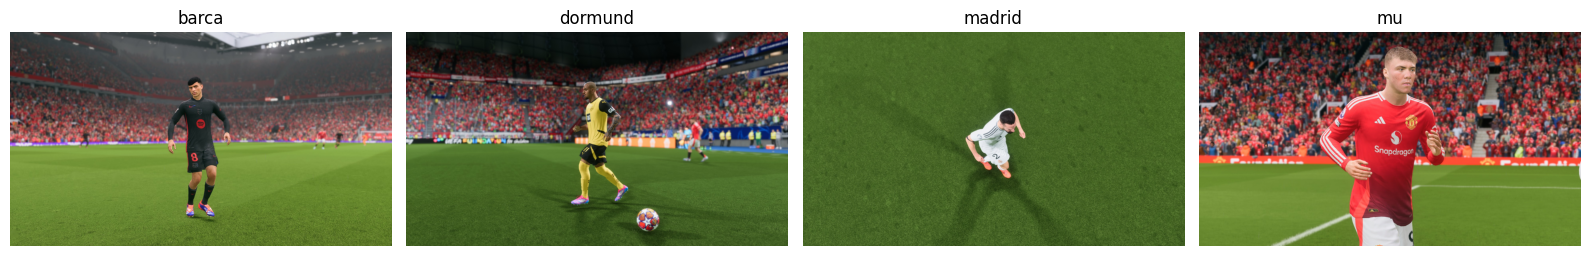

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(df['label'].unique()):
    sample_path = df[df['label'] == label].sample(1)['file'].values[0]
    img = Image.open(sample_path)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

📌 **1. Pembagian Dataset**
- Dataset dibagi menjadi **80% data training** dan **20% data validasi** menggunakan `random_split`.
- `DataLoader` digunakan untuk memuat data ke dalam batch dengan opsi shuffle aktif pada data training.

📌 **2. Penentuan Perangkat (Device)**
- Model akan dijalankan di GPU (`cuda`) jika tersedia, atau CPU sebagai fallback.

📌 **3. Arsitektur Model**
- Menggunakan `obileNetV2`, arsitektur lightweight dari `torchvision.models` yang efisien dan cepat.
- Layer classifier terakhir dimodifikasi untuk menyesuaikan jumlah kelas pada dataset `(len(class_names))`, sehingga bisa digunakan untuk klasifikasi custom.
  
📌 **4. Konfigurasi Training**
- **Loss function**: `CrossEntropyLoss`, cocok untuk klasifikasi multikelas.
- **Optimizer**: Adam, dengan learning rate sebesar 0.001.


In [6]:
def error_analysis(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ganti ResNet18 dengan MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 **Training Loop Selama 50 Epoch**

Loop ini menjalankan proses training dan validasi model selama 50 epoch, mencakup:

🔹 **Training:**
- Model diset ke mode training dengan `model.train()`.
- Dilakukan optimisasi menggunakan **Adam** optimizer.
- Menghitung dan mencatat **loss** serta **akurasi** training per epoch.

🔹 **Validasi:**
- Model diset ke mode evaluasi `model.eval()` dan gradien dimatikan dengan `torch.no_grad()`.
- Loss dan akurasi validasi dihitung tanpa mempengaruhi parameter model.

📈 **Metrik yang Disimpan:**
- `train_losses` & `val_losses`: Menyimpan loss untuk tiap epoch.
- `train_accuracies` & `val_accuracies`: Menyimpan akurasi untuk tiap epoch.

📢 **Output Tiap Epoch:**
- Dicetak ringkasan: `Train Loss`, `Val Loss`, `Train Acc`, dan `Val Acc` agar bisa memantau performa model setiap epoch.


In [9]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/50 - "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/50 - Train Loss: 1.0981, Val Loss: 1.2493 - Train Acc: 0.5845, Val Acc: 0.5081
Epoch 2/50 - Train Loss: 0.8165, Val Loss: 0.7088 - Train Acc: 0.7363, Val Acc: 0.6870
Epoch 3/50 - Train Loss: 0.6571, Val Loss: 0.6340 - Train Acc: 0.7688, Val Acc: 0.7398
Epoch 4/50 - Train Loss: 0.5571, Val Loss: 0.5023 - Train Acc: 0.8035, Val Acc: 0.8008
Epoch 5/50 - Train Loss: 0.5723, Val Loss: 0.4238 - Train Acc: 0.8147, Val Acc: 0.8374
Epoch 6/50 - Train Loss: 0.4413, Val Loss: 0.4268 - Train Acc: 0.8503, Val Acc: 0.8455
Epoch 7/50 - Train Loss: 0.4350, Val Loss: 0.3508 - Train Acc: 0.8523, Val Acc: 0.9024
Epoch 8/50 - Train Loss: 0.3948, Val Loss: 0.3139 - Train Acc: 0.8686, Val Acc: 0.9065
Epoch 9/50 - Train Loss: 0.3284, Val Loss: 0.3001 - Train Acc: 0.8931, Val Acc: 0.8821
Epoch 10/50 - Train Loss: 0.3330, Val Loss: 0.3472 - Train Acc: 0.8819, Val Acc: 0.8780
Epoch 11/50 - Train Loss: 0.3190, Val Loss: 0.3078 - Train Acc: 0.8859, Val Acc: 0.9268
Epoch 12/50 - Train Loss: 0.2715, Val Los

📈 **Loss Curve dan Accuracy Curve per Epoch**

Cell ini menampilkan grafik performa model selama proses training:

🔹 **Loss Curve**  
- Menampilkan perubahan nilai *Train Loss* dan *Validation Loss* per epoch.
- Membantu mengidentifikasi overfitting saat *val loss* meningkat tapi *train loss* menurun.

🔹 **Accuracy Curve**  
- Menampilkan *Train Accuracy* dan *Validation Accuracy*.
- Membantu melihat stabilitas dan peningkatan akurasi seiring waktu.

💡 Dengan grafik ini, kamu bisa memantau apakah model belajar dengan baik atau mengalami overfitting/underfitting.

In [10]:
import matplotlib.pyplot as plt

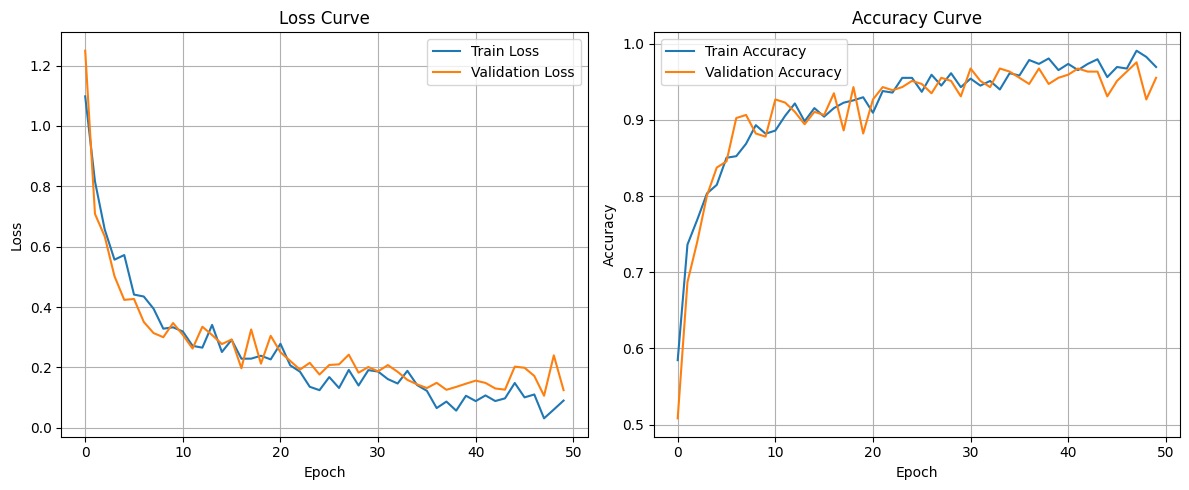

In [11]:
# Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📝 **Classification Report**  
- Menghitung metrik evaluasi untuk model berdasarkan hasil prediksi pada data validasi.
- Metrik yang dihitung: 
    - **Precision**: Kemampuan model untuk memprediksi label positif dengan benar.
    - **Recall**: Kemampuan model untuk menemukan semua label positif yang sebenarnya.
    - **F1-Score**: Harmonik rata-rata antara Precision dan Recall.
  
💡 Dengan `classification_report`, kamu bisa mendapatkan gambaran umum mengenai kualitas prediksi model untuk setiap kelas.

📊 **Confusion Matrix**  
- Menampilkan visualisasi kesalahan klasifikasi antara label sebenarnya dan prediksi model.
- Diwakili dalam matriks, di mana nilai diagonal menunjukkan prediksi yang benar, dan nilai di luar diagonal menunjukkan kesalahan klasifikasi.

🔥 **Heatmap Confusion Matrix**  
- Untuk mempermudah pemahaman, matriks ditampilkan dalam bentuk heatmap dengan warna yang lebih gelap menunjukkan kesalahan yang lebih besar.

📄 Classification Report:

              precision    recall  f1-score   support

       barca       0.98      0.92      0.95        66
     dormund       0.89      0.95      0.92        60
      madrid       0.95      0.97      0.96        64
          mu       1.00      0.98      0.99        56

    accuracy                           0.96       246
   macro avg       0.96      0.96      0.96       246
weighted avg       0.96      0.96      0.96       246



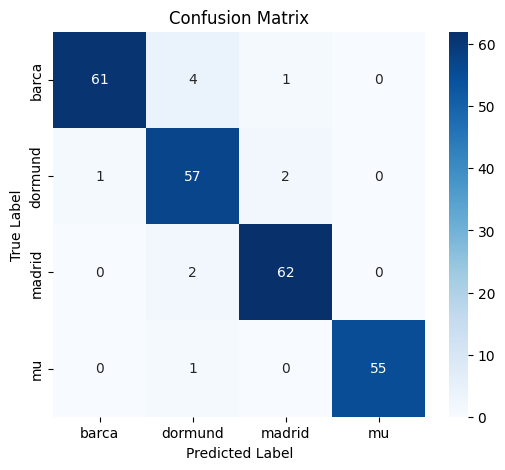

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Pastikan class_names sesuai label folder kamu
class_names = ['barca', 'dormund', 'madrid', 'mu']

# Kumpulkan semua prediksi dan label sebenarnya dari validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report (Precision, Recall, F1-score)
print("📄 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 🔥 Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 📸 Upload Gambar dan Prediksi Kelas dengan MobileNetV2

Kode berikut memungkinkan pengguna untuk mengunggah gambar baru, yang kemudian akan diprediksi kelasnya menggunakan model MobileNetV2 yang telah dimodifikasi sesuai jumlah kelas dataset.

#### ✅ Fitur:
- Menggunakan **widget upload gambar interaktif**
- **Menampilkan hasil prediksi** di console
- **Menampilkan gambar beserta label prediksi** secara visual

#### 🧠 Langkah-langkah:
1. Model `MobileNetV2` di-load dengan pretrained weight dari ImageNet.
2. Layer classifier terakhir diganti agar sesuai dengan jumlah kelas pada dataset kita.
3. Gambar yang diupload akan di-preprocessing menggunakan transformasi standar.
4. Setelah prediksi dilakukan, hasilnya akan:
   - Ditampilkan pada output console (`print`)
   - Ditampilkan juga dengan `matplotlib` langsung di notebook

#### 📦 Dependensi yang digunakan:
- `torch`, `torchvision`, `PIL`, `ipywidgets`, `matplotlib`

Cukup jalankan cell ini, lalu upload gambar menggunakan widget yang muncul untuk melihat hasil prediksi.


In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Menentukan device (GPU jika ada, atau CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memuat model MobileNetV2 pretrained
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.classifier[1] = torch.nn.Linear(model.last_channel, len(class_names))  # Output layer sesuai jumlah kelas
model = model.to(device)
model.eval()

# Transformasi untuk preprocessing gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ukuran gambar input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi dengan nilai ImageNet
])

# Fungsi untuk melakukan prediksi dan menampilkan hasilnya di console
def predict_image(image_data, transform, model, class_names):
    img = Image.open(BytesIO(image_data)).convert('RGB')
    
    # Preprocessing gambar
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Melakukan prediksi
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]
        
        # Menampilkan gambar dan hasil prediksi di console
        print(f"Predicted class: {predicted_class}")
        
        # Menampilkan gambar
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Widget untuk upload file gambar
def upload_and_predict(class_names):
    upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
    display(upload_widget)

    def on_upload_change(change):
        uploaded_image = upload_widget.value[0]
        image_data = uploaded_image['content']
        predict_image(image_data, transform, model, class_names)

    upload_widget.observe(on_upload_change, names='value')

# Memulai session upload dan prediksi
upload_and_predict(class_names)


FileUpload(value=(), accept='image/*', description='Upload')

## Hasil yang muncul dari prediksi

Dalam mencoba cell ini, saya mengambil gambar baru dari seorang pemain MU dan menginputkan gambarnya untuk di prediksi dan hasilnya benar. Berikut di bawah ini merupakan output `console` dari cell codingan diatas.

`FileUpload(value=(), accept='image/*', description='Upload')
Predicted class: mu`
